In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ecg-dataset/ecg.csv
/kaggle/input/eeg-and-ecg-datasets/mitbih_test.csv
/kaggle/input/eeg-and-ecg-datasets/mitbih_train.csv
/kaggle/input/eeg-and-ecg-datasets/Epileptic Seizure Recognition Data Set.csv
/kaggle/input/ecg-signal/ECG.dat


In [2]:
import os
print(os.getcwd())

/kaggle/working


<hr style="border: solid 3px blue;">

# Introduction

![blog.keras.io](https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/heart-beat-anomaly.gif)

Picture credit: https://cainvas-static.s3.amazonaws.com

**What is anomaly detection?**
> Anomaly detection (aka outlier analysis) is a step in data mining that identifies data points, events, and/or observations that deviate from a dataset’s normal behavior. Anomalous data can indicate critical incidents, such as a technical glitch, or potential opportunities, for instance a change in consumer behavior. Machine learning is progressively being used to automate anomaly detection.

Ref: https://www.anodot.com/blog/what-is-anomaly-detection



----------------------------------
**Autoencoder-based anomaly detection**

> **Autoencoder-based anomaly detection** is to perform anomaly detection by compressing normal data into a latent space of a smaller dimension than the original data through the autoencoder, then restoring it and comparing the difference between the restored data and the original data. 
> The part that encodes the normal data to the lower dimension is called the encoder, and the part that decodes the compressed sample back to the original dimension is called the decoder. 
> The data expression in the latent space where the data is compressed by the encoder is called a latent variable. The autoencoder learns through the process of minimizing the difference between the original data and the restored data, and in the process, the features of the learning data are naturally extracted to construct a latent space.
>
> The specific way an autoencoder compares the input and output differences also determines the performance and characteristics of anomaly detection. The most basic method considers the original data and the restored data as points in the n-dimensional coordinate space, and uses the distance between the two points as an index of the input/output difference. This metric is called the reconstruction error. Since the autoencoder used for anomaly detection is trained to restore normal data well, compression and restoration cannot be performed effectively when abnormal data is input. Therefore, the abnormal data has a large restoration error.
>
> The restoration error can be used as one of the anomaly scores that indicate the degree of anomaly of a given data. If the anomaly score is greater than a predetermined threshold, the data is considered anomaly, and if it is small, it is considered normal. Thresholds are set differently depending on the specific characteristics and requirements of the anomaly detection you want to perform.

------------------------------------------------------------------
## What is Autoencoder?

![](https://lilianweng.github.io/lil-log/assets/images/autoencoder-architecture.png)

Picture Credit: https://lilianweng.github.io

The auto encoder learns to produce the same output as the input as much as possible. Through this learning process, the representation of the input can be effectively compressed in the latent space. In other words, it compresses the dimensions and stores the representation of the input in the latent space.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

import umap
import umap.plot

from plotly.subplots import make_subplots
import plotly.graph_objects as go

> This dataset contains the ECG readings of patients.
> Each row corresponds to a single complete ECG of a patient. Every single ECG is composed of 140 data points(readings).
>  
> 1. Columns 0-139 contain the ECG data point for a particular patient. These are floating point numbers.
> 2. The label which shows whether the ECG is normal or abnormal. It is a categorical variable with value either 0 or 1.

-------------------------------------------------
# Utility Functions

In [4]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)   
     
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('confusion matrix')
    print(confusion)

    # ROC-AUC print 
    print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    return confusion

------------------------------------------
# Doing Simple EDA

In [5]:
dataframe = pd.read_csv('/kaggle/input/ecg-dataset/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head().style.set_properties(**{'background-color': 'black',
                           'color': 'white',
                           'border-color': 'white'})

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,-0.363808,-0.491957,-0.421855,-0.309201,-0.495939,-0.342119,-0.355336,-0.367913,-0.316503,-0.412374,-0.471672,-0.413458,-0.364617,-0.449298,-0.471419,-0.424777,-0.462517,-0.552472,-0.475375,-0.694200,-0.701868,-0.593812,-0.660684,-0.713831,-0.769807,-0.672282,-0.653676,-0.639406,-0.559302,-0.591670,-0.493223,-0.463052,-0.301644,-0.232734,-0.125055,-0.153943,-0.024357,-0.065609,0.034999,0.061935,0.071195,0.123925,0.103124,0.225228,0.128683,0.302483,0.257276,0.196352,0.179383,0.244729,0.341217,0.328204,0.406042,0.446605,0.424068,0.481512,0.477844,0.624083,0.574585,0.598013,0.564592,0.607979,0.620635,0.656253,0.684748,0.694273,0.665584,0.575796,0.638135,0.614917,0.569083,0.468576,0.442818,0.468274,0.432493,0.407958,0.418623,0.362531,0.410959,0.471666,0.372167,0.337875,0.221405,0.273997,0.298664,0.263564,0.342564,0.419505,0.586607,0.860624,1.173345,1.258179,1.433789,1.700533,1.999043,2.125341,1.993291,1.932246,1.797437,1.522284,1.251168,0.998730,0.483722,0.023132,-0.194914,-0.220917,-0.243737,-0.254695,-0.291136,-0.256490,-0.227874,-0.322423,-0.289286,-0.318170,-0.363654,-0.393456,-0.266419,-0.256823,-0.288694,-0.162338,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.000000
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,0.148951,0.183527,0.294876,0.190233,0.235575,0.253487,0.221742,0.050233,0.178042,0.139563,0.046794,0.043007,0.106544,0.012654,0.003995,0.045724,-0.045999,-0.072667,-0.071078,-0.153866,-0.227254,-0.249270,-0.253489,-0.332835,-0.264330,-0.345825,-0.310781,-0.334160,-0.306178,-0.174563,-0.206160,-0.224480,-0.048684,-0.019621,0.094805,0.116786,0.185186,0.230526,0.138027,0.244426,0.271695,0.259003,0.269202,0.127065,0.202073,0.255983,0.153115,0.210216,0.191082,0.190927,0.210510,0.207108,0.204888,0.200865,0.346920,0.348002,0.254537,0.331975,0.356690,0.349930,0.430380,0.467502,0.486063,0.403188,0.478956,0.397392,0.464120,0.451795,0.361361,0.379831,0.342785,0.399107,0.387508,0.255703,0.284034,0.284993,0.250108,0.173036,0.149423,0.141685,0.222261,0.172847,0.150779,0.176566,0.280942,0.489939,0.660889,0.893193,1.026997,1.202394,1.557410,1.808428,2.164346,2.070747,1.903614,1.764455,1.507769,1.293428,0.894562,0.578016,0.244343,-0.286443,-0.515881,-0.732707,-0.832465,-0.803318,-0.836252,-0.777865,-0.774753,-0.733404,-0.721386,-0.832095,-0.711982,-0.751867,-0.757720,-0.853120,-0.766988,-0.688161,-0.519923,0.039406,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.000000
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,-0.282897,-0.356926,-0.287297,-0.399489,-0.473244,-0.379048,-0.399039,-0.178594,-0.339522,-0.498447,-0.337251,-0.425480,-0.423952,-0.463170,-0.493253,-0.549749,-0.529831,-0.530935,-0.502365,-0.417368,-0.526346,-0.471005,-0.676784,-0.898612,-0.610571,-0.530164,-0.765674,-0.581937,-0.537848,-0.556386,-0.438023,-0.436248,-0.400114,-0.134987,-0.239347,-0.120244,-0.001971,0.285000,0.315646,0.107364,0.109521,0.158078,0.291898,0.261294,0.188407,0.140651,0.263365,0.287207,0.314317,0.177942,0.138290,0.321069,0.458168,0.251916,0.261353,0.277488,0.298793,0.459075,0.419147,0.520509,0.537761,0.603211,0.475634,0.521693,0.735248,0.729541,0.718523,0.498433,0.545441,0.604827,0.521296,0.394381,0.405020,0.597563,0.531130,0.377651,0.467701,0.457569,0.341116,0.407913,0.459127,0.403937,0.298191,0.46110

## Checking Target Imblance

In [6]:
colors = ['gold', 'mediumturquoise']
labels = ['Normal','Abnormal']
values = dataframe[140].value_counts()/dataframe[140].shape[0]

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.update_traces(hoverinfo='label+percent', textinfo='percent', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='white', width=0.1)))
fig.update_layout(
    title_text="ECG dataset",
    title_font_color="white",
    legend_title_font_color="yellow",
    paper_bgcolor="black",
    plot_bgcolor='black',
    font_color="white",
)
fig.show()

**OK! Target distribution is balanced.**

----------------------------------------------------
# Splitting Dataset

In [7]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

-----------------------------------------------------------------------
# Preprocessing

In [8]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

Train the autoencoder using only the normal rhythm labeled 1 on this dataset. Separates normal and abnormal rhythms.

In [9]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

print("the length of train :",len(train_labels))
print("the length of test :",len(test_labels))

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

the length of train : 3998
the length of test : 1000


Plot the normal ECG.

Text(0.5, 1.0, 'A Normal ECG')

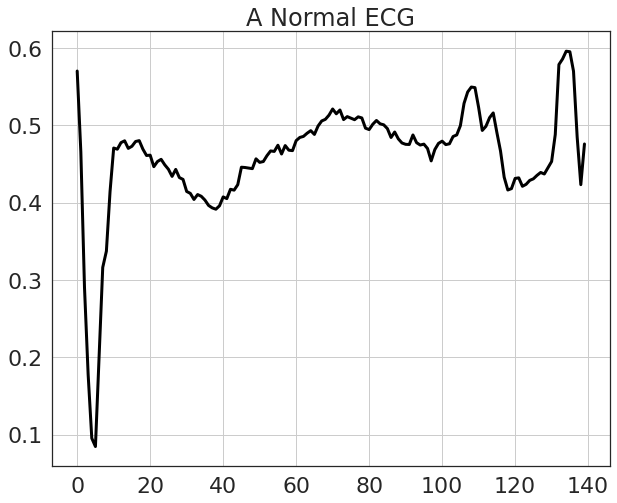

In [10]:
plt.figure(figsize=(10,8))
sns.set(font_scale = 2)
sns.set_style("white")
plt.grid()
plt.plot(np.arange(140), normal_train_data[0],color='black',linewidth=3.0)
plt.title("A Normal ECG")

Plot the abnormal ECG.

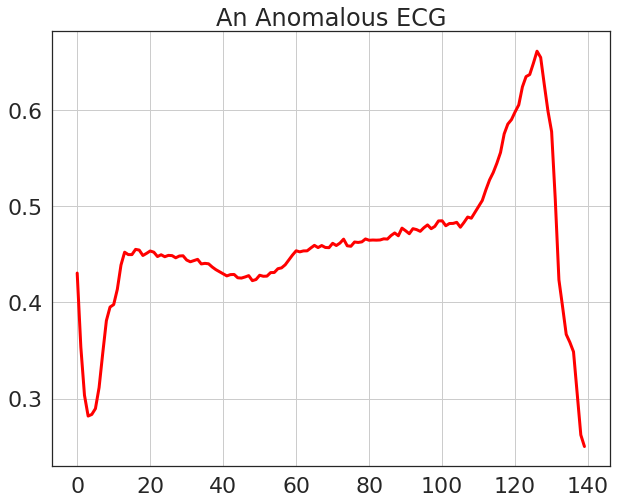

In [11]:
plt.figure(figsize=(10,8))
sns.set(font_scale = 2)
sns.set_style("white")
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0],color='red',linewidth=3.0)
plt.title("An Anomalous ECG")
plt.show()

-----------------------------------
# Modeling

In [12]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])
    
    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [13]:
autoencoder.compile(optimizer='adam', loss='mae')

-----------------------------
# Training
The autoencoder is trained using only regular ECGs, but evaluated using the full test set.

In [14]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=20, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20
5/5 [==============================] - 2s 246ms/step - loss: 0.0586 - val_loss: 0.0524
Epoch 2/20
5/5 [==============================] - 0s 18ms/step - loss: 0.0547 - val_loss: 0.0507
Epoch 3/20
5/5 [==============================] - 0s 18ms/step - loss: 0.0509 - val_loss: 0.0481
Epoch 4/20
5/5 [==============================] - 0s 17ms/step - loss: 0.0465 - val_loss: 0.0458
Epoch 5/20
5/5 [==============================] - 0s 17ms/step - loss: 0.0421 - val_loss: 0.0437
Epoch 6/20
5/5 [==============================] - 0s 18ms/step - loss: 0.0383 - val_loss: 0.0418
Epoch 7/20
5/5 [==============================] - 0s 18ms/step - loss: 0.0348 - val_loss: 0.0404
Epoch 8/20
5/5 [==============================] - 0s 17ms/step - loss: 0.0323 - val_loss: 0.0392
Epoch 9/20
5/5 [==============================] - 0s 18ms/step - loss: 0.0301 - val_loss: 0.0384
Epoch 10/20
5/5 [==============================] - 0s 17ms/step - loss: 0.0288 - val_loss: 0.0377
Epoch 11/20
5/5 [===========

In [15]:
autoencoder.save("ecg_reconstruction_model.HDF5")

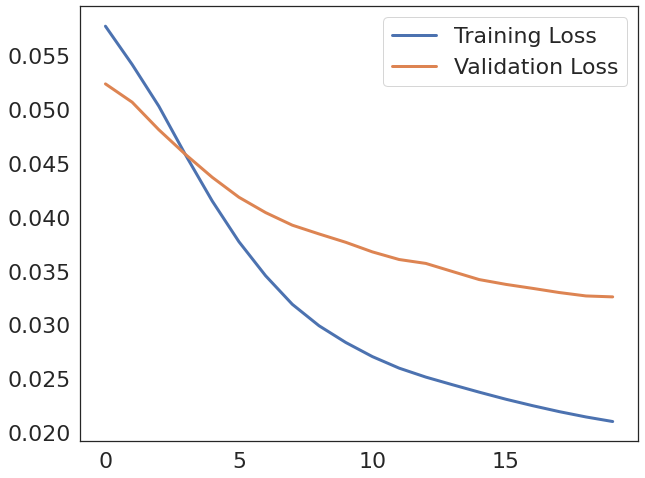

In [16]:
plt.figure(figsize=(10,8))
sns.set(font_scale = 2)
sns.set_style("white")
plt.plot(history.history["loss"], label="Training Loss",linewidth=3.0)
plt.plot(history.history["val_loss"], label="Validation Loss",linewidth=3.0)
plt.legend()

If the reconstruction error is greater than one standard deviation from the normal training example, classify the ECG as abnormal. First, let's plot the normal ECG of the training set, the reconstruction after being encoded and decoded by the autoencoder, and the reconstruction error.

---------------------------------------------
# Testing using normal data

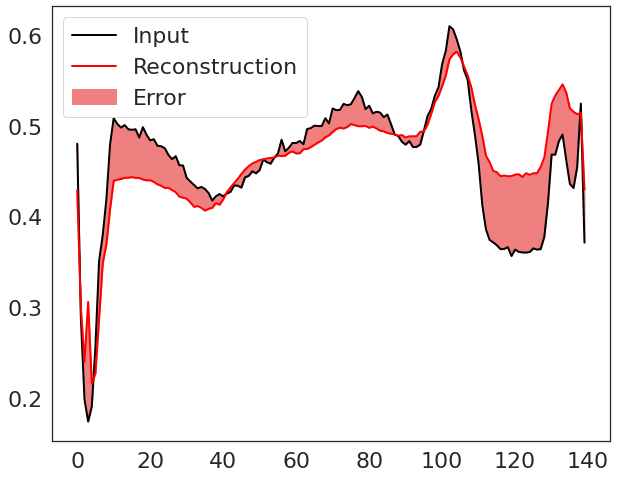

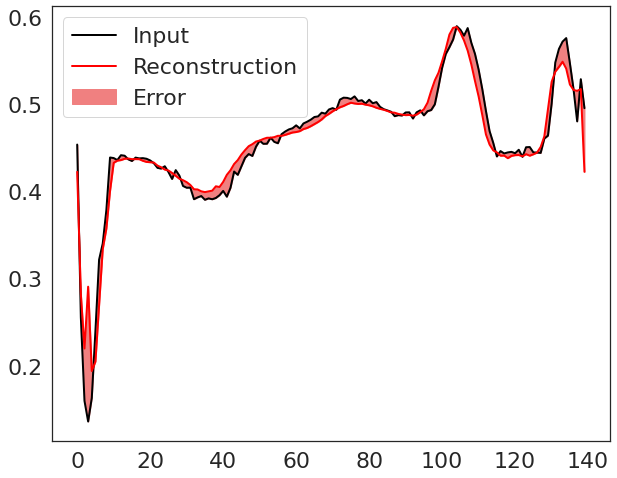

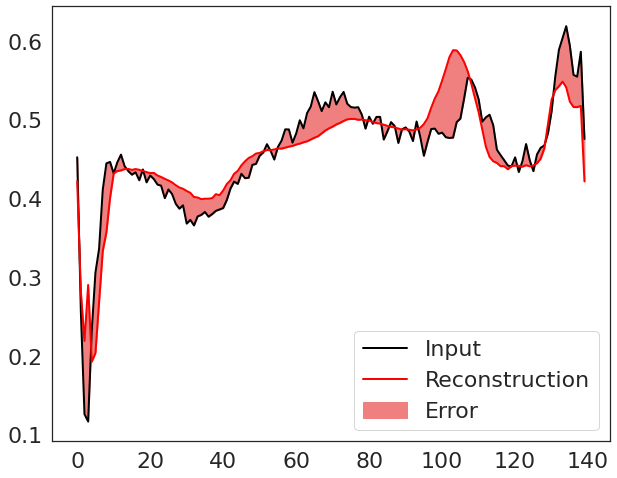

In [17]:
encoded_imgs = autoencoder.encoder(normal_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

for i in range(0,3):
    plt.figure(figsize=(10,8))
    sns.set(font_scale = 2)
    sns.set_style("white")
    plt.plot(normal_test_data[i], 'black',linewidth=2)
    plt.plot(decoded_imgs[i], 'red',linewidth=2)
    plt.fill_between(np.arange(140), decoded_imgs[i], normal_test_data[i], color='lightcoral')
    plt.legend(labels=["Input", "Reconstruction", "Error"])
    plt.show()

In [18]:
encoded_imgs_normal = pd.DataFrame(encoded_imgs)
encoded_imgs_normal['label'] = 1

-------------------------------------------
# Testing using abnormal data

Create a similar plot, this time from abnormal testing examples.

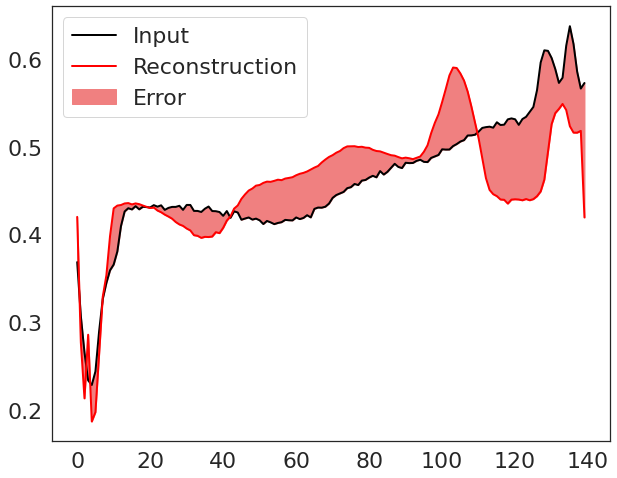

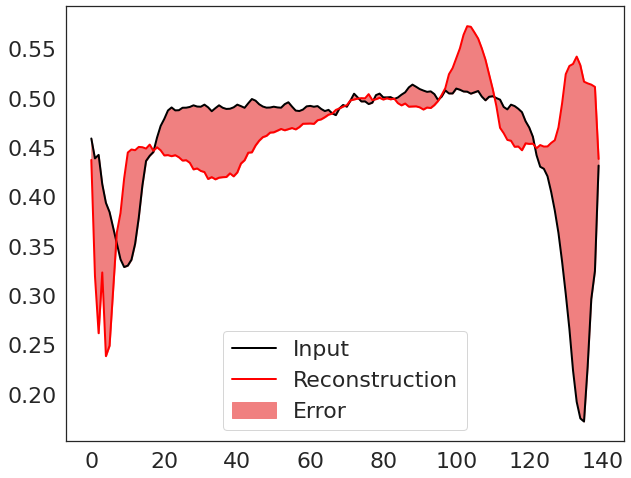

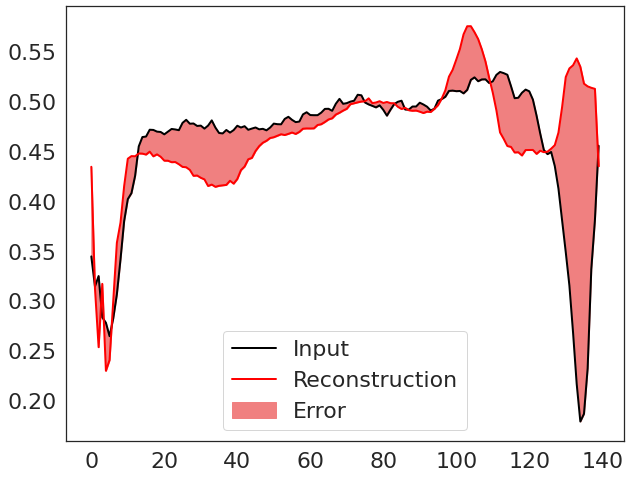

In [19]:
encoded_imgs = autoencoder.encoder(anomalous_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

for i in range(0,3):
    plt.figure(figsize=(10,8))
    sns.set(font_scale = 2)
    sns.set_style("white")
    plt.plot(anomalous_test_data[i], 'black',linewidth=2)
    plt.plot(decoded_imgs[i], 'red',linewidth=2)
    plt.fill_between(np.arange(140), decoded_imgs[i], anomalous_test_data[i], color='lightcoral')
    plt.legend(labels=["Input", "Reconstruction", "Error"])
    plt.show()

In [20]:
encoded_imgs_abnormal = pd.DataFrame(encoded_imgs)
encoded_imgs_abnormal['label'] = 0

----------------------------------------------------------------------------
# Ploting the Latent Space after Dimension Reduction

In [21]:
all_encoded = pd.concat([encoded_imgs_normal,encoded_imgs_abnormal])

<AxesSubplot:>

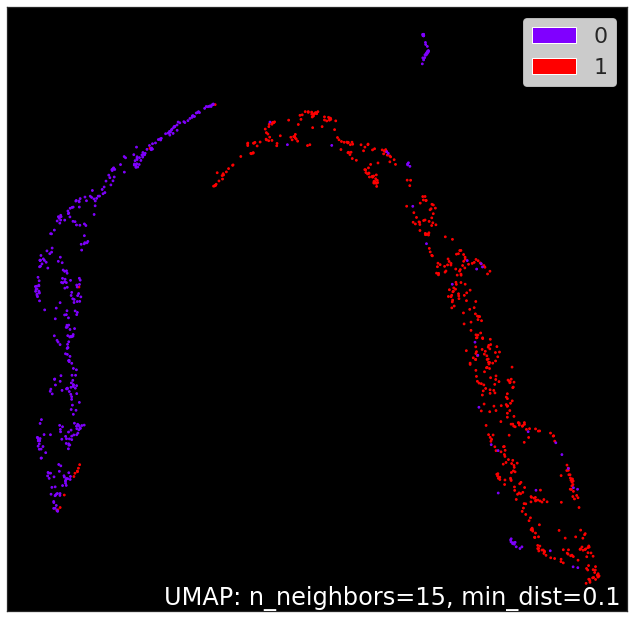

In [22]:
mapper = umap.UMAP().fit(all_encoded.iloc[:,:8])
umap.plot.points(mapper, labels=all_encoded.iloc[:,8], theme='fire')

The figure above shows Dimension Reduction of the latent space for normal and abnormal data. This latent space is a space that has undergone Dimension Reduction by compressing 140-dimensional input into 8-dimensional space.
We compressed this space back into two dimensions to obtain the picture above.

Looking at the above figure again, it can be confirmed that normal and abnormal data are well separated in the latent space. This is the power of autoencoders, and it can be seen as one of the ways to solve the dimensional curse from the neural network point of view.

It will be helpful to refer to the notebook below in Dimension Reduction.

https://www.kaggle.com/ohseokkim/the-curse-of-dimensionality-dimension-reduction

## UMAP connectivity plot
> UMAP works by constructing an intermediate topological representation of the approximate manifold the data may have been sampled from. In practice this structure can be simplified down to a weighted graph. Sometimes it can be beneficial to see how that graph (representing connectivity in the manifold) looks with respect to the resulting embedding. It can be used to better understand the embedding, and for diagnostic purposes.

Ref: https://umap-learn.readthedocs.io

<AxesSubplot:>

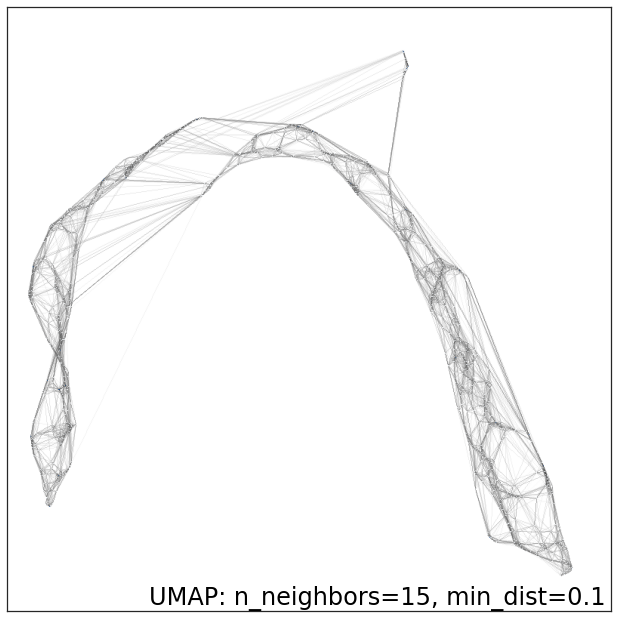

In [23]:
umap.plot.connectivity(mapper, show_points=True)

<hr style="border: solid 3px blue;">

# Detecting Anomaly

Anomalies are detected by calculating whether the reconstruction loss is greater than a fixed threshold. In this tutorial, we compute the mean error for normal examples in the training set, and then classify future examples as abnormal if the reconstruction error is greater than the standard deviation of the training set.

Plot the reconstruction error for normal ECGs in the training set.

In [24]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

In [25]:
np.mean(train_loss)

0.02076812

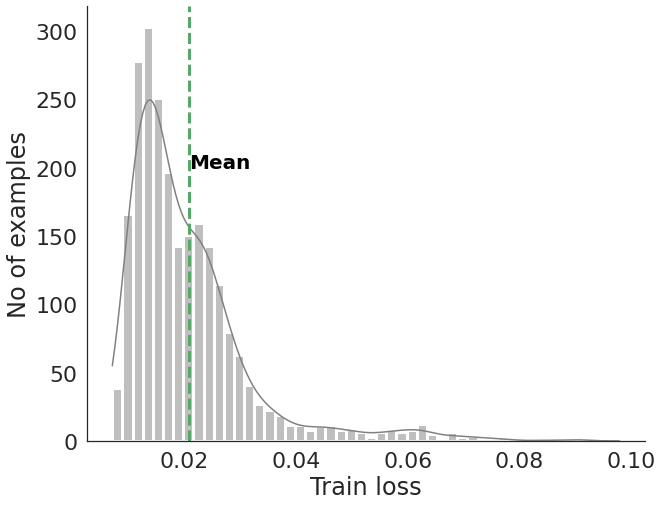

In [26]:
plt.figure(figsize=(10,8))
sns.set(font_scale = 2)
sns.set_style("white")
sns.histplot(train_loss ,bins=50,kde=True,color='grey',linewidth=3)
plt.axvline(x=np.mean(train_loss), color='g', linestyle='--', linewidth=3)
plt.text(np.mean(train_loss), 200, "Mean", horizontalalignment='left', 
         size='small', color='black', weight='semibold')
plt.xlabel("Train loss")
plt.ylabel("No of examples")
sns.despine()

Let's choose a threshold with a standard deviation higher than the mean.

In [27]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.03249857


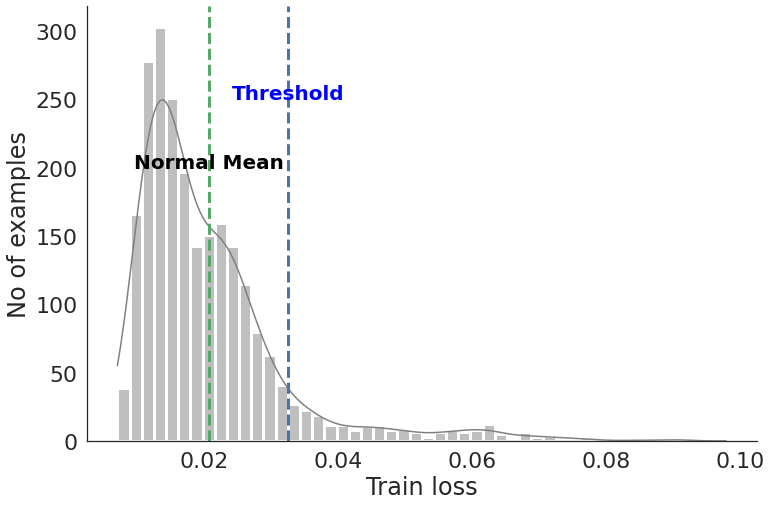

In [28]:
plt.figure(figsize=(12,8))
sns.set(font_scale = 2)
sns.set_style("white")
sns.histplot(train_loss ,bins=50,kde=True,color='grey',linewidth=3)
plt.axvline(x=np.mean(train_loss), color='g', linestyle='--', linewidth=3)
plt.text(np.mean(train_loss), 200, "Normal Mean", horizontalalignment='center', 
         size='small', color='black', weight='semibold')
plt.axvline(x=threshold, color='b', linestyle='--', linewidth=3)
plt.text(threshold, 250, "Threshold", horizontalalignment='center', 
         size='small', color='Blue', weight='semibold')
plt.xlabel("Train loss")
plt.ylabel("No of examples")
sns.despine()

**Examining reconstruction errors for unusual examples in the test set reveals that most of them have reconstruction errors greater than the threshold(blue-dotted line=0.033).**

In [29]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

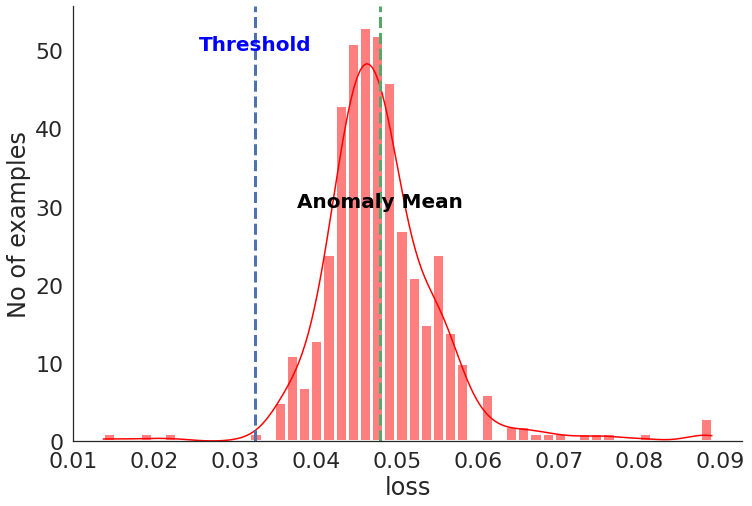

In [30]:
plt.figure(figsize=(12,8))
sns.set(font_scale = 2)
sns.set_style("white")
sns.histplot(test_loss ,bins=50,kde=True,color='red',linewidth=3)
plt.axvline(x=np.mean(test_loss), color='g', linestyle='--', linewidth=3)
plt.text(np.mean(test_loss), 30, "Anomaly Mean", horizontalalignment='center', 
         size='small', color='black', weight='semibold')
plt.text(threshold, 50, "Threshold", horizontalalignment='center', 
         size='small', color='Blue', weight='semibold')
plt.axvline(x=threshold, color='b', linestyle='--', linewidth=3)
plt.xlabel("loss")
plt.ylabel("No of examples")
sns.despine()

If the reconstruction error is greater than the threshold(blue-dotted line), classify the ECG as abnormal.

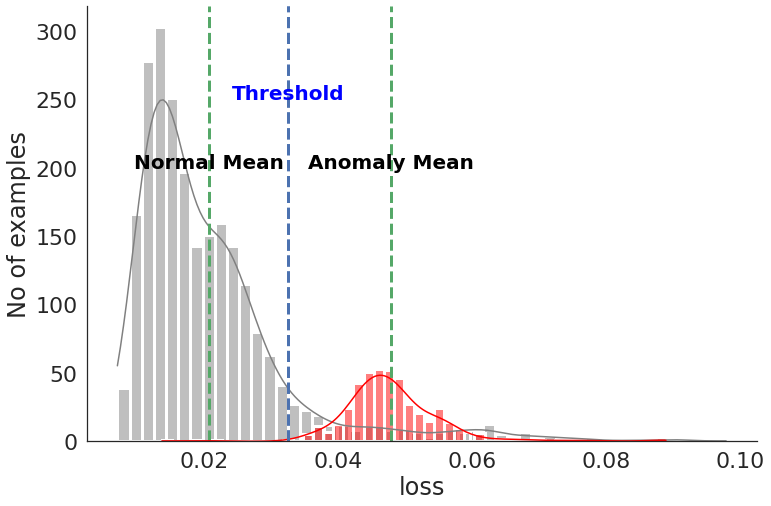

In [31]:
plt.figure(figsize=(12,8))
sns.set(font_scale = 2)
sns.set_style("white")
sns.histplot(train_loss ,bins=50,kde=True,color='grey',linewidth=3)
plt.axvline(x=np.mean(train_loss), color='g', linestyle='--', linewidth=3)
plt.text(np.mean(train_loss), 200, "Normal Mean", horizontalalignment='center', 
         size='small', color='black', weight='semibold')
plt.axvline(x=threshold, color='b', linestyle='--', linewidth=3)
plt.text(threshold, 250, "Threshold", horizontalalignment='center', 
         size='small', color='Blue', weight='semibold')

sns.histplot(test_loss ,bins=50,kde=True,color='red',linewidth=3)
plt.axvline(x=np.mean(test_loss), color='g', linestyle='--', linewidth=3)
plt.text(np.mean(test_loss), 200, "Anomaly Mean", horizontalalignment='center', 
         size='small', color='black', weight='semibold')
plt.axvline(x=threshold, color='b', linestyle='--', linewidth=3)
plt.xlabel("loss")
plt.ylabel("No of examples")
sns.despine()

Looking at the picture above, it seems that the threshold was set by considering the Normal and Anomaly distributions well. In particular, it seems that recall is more important than precision for abnomaly detection. In actual application, it may be necessary to consider fine-tuning the threshold.

---------------------------------------------------------------
# Predicting

In [32]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, preds)))
  print("Precision = {}".format(precision_score(labels, preds)))
  print("Recall = {}".format(recall_score(labels, preds)))

In [33]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.943
Precision = 0.9921722113502935
Recall = 0.9053571428571429


confusion matrix
[[436   4]
 [ 53 507]]
accuracy: 0.9430, precision: 0.9922, recall: 0.9054,    F1: 0.9468, AUC:0.9481


<AxesSubplot:>

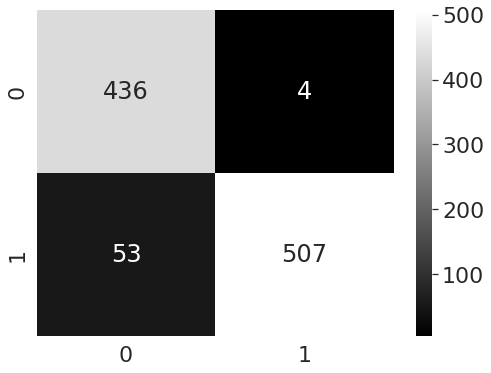

In [34]:
confusion_matrix = get_clf_eval(test_labels,preds,preds)
plt.figure(figsize=(8,6))
sns.set(font_scale = 2)
sns.set_style("white")
sns.heatmap(confusion_matrix, cmap = 'gist_yarg_r',annot = True, fmt='d')